<a href="https://colab.research.google.com/github/dantebarross/scientific-projects-with-python/blob/main/Denoising_noisy_signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising noisy signals

Let's work with some time series data, simulating interesting time series data, adding noise to them, exploring methods for removing/filtring noise in noise signals and evaluating the methods and its parameters.

## Smoothing via running-mean filter

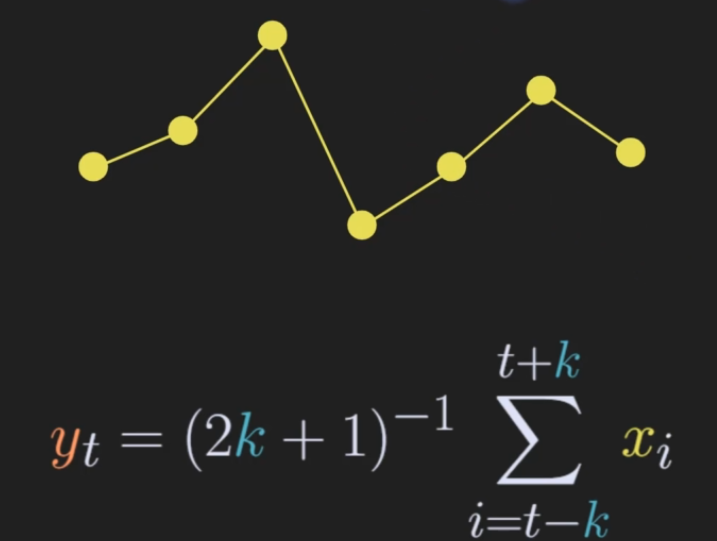

The running-mean filter is followed by this formula above. Although the equation looks scary, it isn't. Let's translate into code and show that.

With a data time series "x", we want to get a new filtered data "y", where in each time point "t" we sum over values of the original signal "x" going from "t - k" to "t + k", where "k" is some random number. And then we divide by "2k + 1" (that is the normalization to get this from a sum into a mean/average).

Let's imagine we take this three time points, and take the sum from the previous point to the current point and the next point, then we divide by 2k + 1

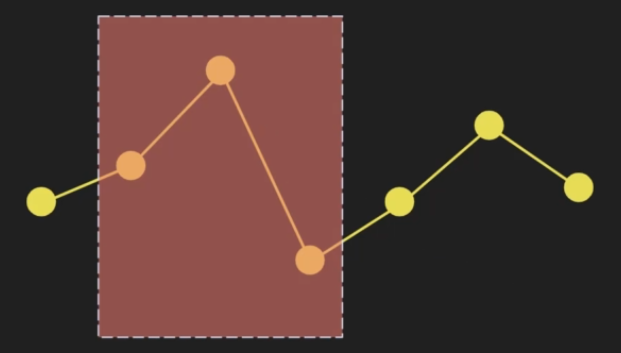

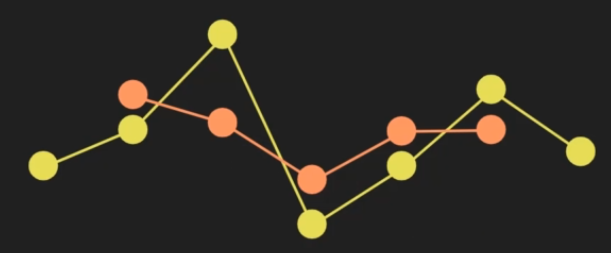

The "y" filtered signal is going to look like the orange signal.

But first, let's create a pure, noiseless signal with this equation (one in infinite possibilities).

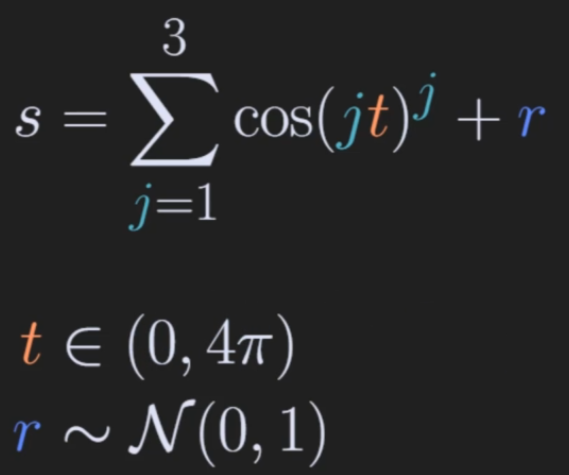

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import copy

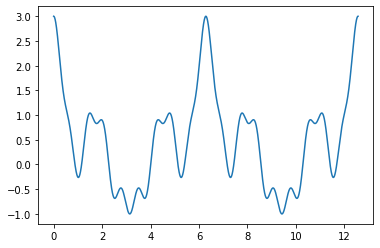

In [7]:
N = 10001
time = np.linspace(0, 4 * np.pi, N)
signal = np.zeros(N)

for j in range(1, 4):
  signal += np.cos(j*time)**j

plt.plot(time, signal); # our original signal

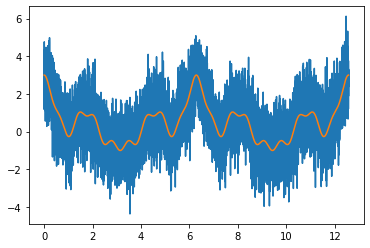

In [18]:
noisy_signal = signal + np.random.randn(N)
plt.plot(time, noisy_signal, time, signal)
plt.show()

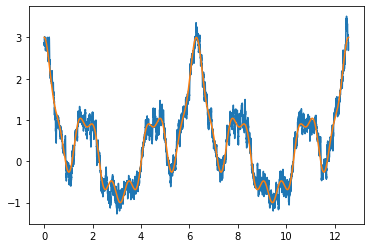

In [19]:
# Running-mean filter

filtered_signal = copy.deepcopy(noisy_signal)  # let's preserve this noisy signal to compare later
k = 15

for t in range(N):
  lowbnd = np.max((0, t-k)) # if t-k is negative, then we go with zero
  uppbnd = np.min((N, t+k)) # if t+k is outside boundary, we go with N
  filtered_signal[t] = np.mean(noisy_signal[lowbnd : uppbnd])

plt.plot(time, filtered_signal, time, signal);

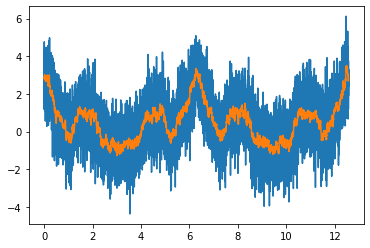

In [20]:
plt.plot(time, noisy_signal, time, filtered_signal);

In [21]:
# defining a function to filter the signals
def mean_smooth(signal_input, k):
  filtered_signal = copy.deepcopy(signal_input)
  for t in range(N):
    lowbnd = np.max((0, t-k)) # if t-k is negative, then we go with zero
    uppbnd = np.min((N, t+k)) # if t+k is outside boundary, we go with N
    filtered_signal[t] = np.mean(noisy_signal[lowbnd : uppbnd])
  return filtered_signal

In [22]:
k_values = np.arange(5, 41) # 5 to 40
signal_correlations = []

for k_index in k_values:
  # filtering the signal
  filtered_sig = mean_smooth(noisy_signal, k_index)

  # computing the correlation signal and original
  signal_correlations.append(np.corrcoef(filtered_sig, signal)[0, 1])

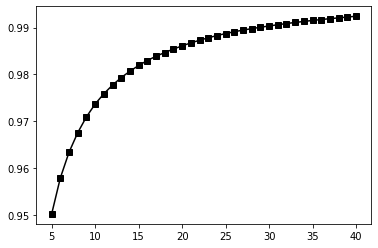

In [25]:
plt.plot(k_values, signal_correlations, 'ks-');

## Smoothing via Gaussian convolution

Conceptually is very similar to the mean smoothing filter, but it's implemented in a different way.

The signal follows the formula below, where "t" is cubed, plus the signal of (t), then detrend the resulted value, and add noise "r".

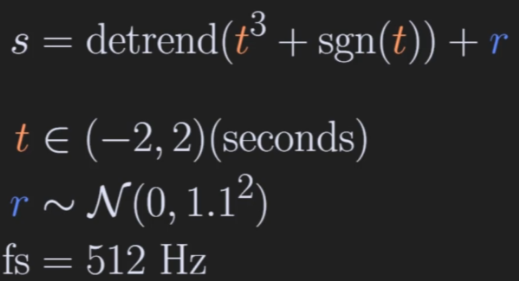

Then to do the smoothing via Gaussian convolution, we create a Gaussian, with the formula below:

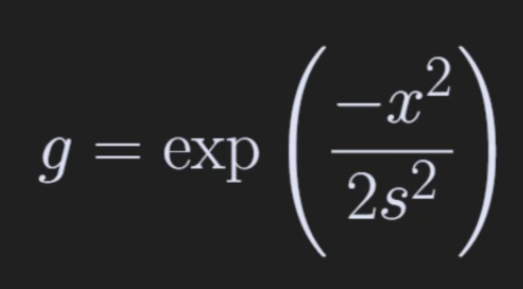

Then we are going to apply sum of squared errors (SSE), a metric of difference between two signals. 

This is calculated by the sum over all the squared difference between filtered data points and the original signal.

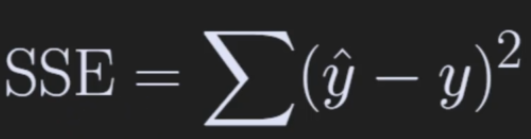

In [27]:
# Creating signal

sampling_rate = 512
time = np.arange(-2, 2 + 1 / sampling_rate, 1 / sampling_rate)
time

array([-2.        , -1.99804688, -1.99609375, ...,  1.99609375,
        1.99804688,  2.        ])

In [29]:
time_points = len(time)
time_points

2049

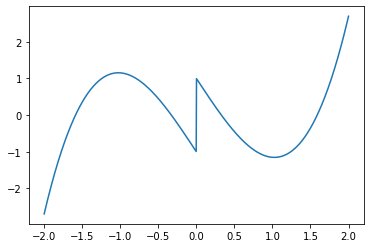

In [31]:
from scipy.signal import detrend

signal = detrend(time**3 + np.sign(time))
plt.plot(time, signal);

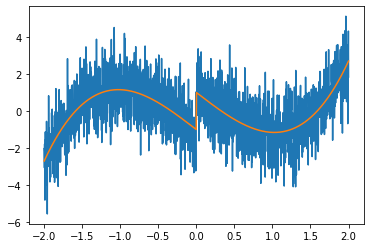

In [33]:
noisy_signal = signal + np.random.randn(time_points) * 1.1

plt.plot(time, noisy_signal, time, signal);

In [36]:
# Creating the Gaussian

k = 10
x = np.arange(-k, k+1) / sampling_rate
x

array([-0.01953125, -0.01757812, -0.015625  , -0.01367188, -0.01171875,
       -0.00976562, -0.0078125 , -0.00585938, -0.00390625, -0.00195312,
        0.        ,  0.00195312,  0.00390625,  0.00585938,  0.0078125 ,
        0.00976562,  0.01171875,  0.01367188,  0.015625  ,  0.01757812,
        0.01953125])

Text(0.5, 1.0, 'n=21, s=0.005')

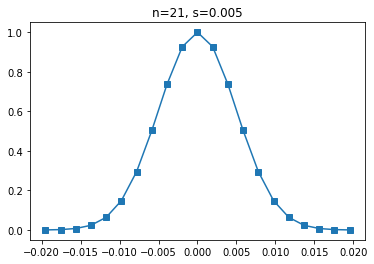

In [39]:
s = .005
g_kernel = np.exp(-x**2 / (2 * s**2))
plt.plot(x, g_kernel, 's-');
plt.title('n=%s, s=%g'%(2*k+1, s))

Now we are going to slide this Gaussian all along the data, computing the dot product (element-wise multiplication and sum between gaussian kernel and the noisy signal). 

It's not just computing the average here, but a weighted average (where time points at the center are stronger in Gaussian distribution).

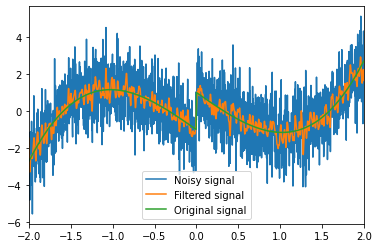

In [47]:
g_kernel /= sum(g_kernel) # dividing by the number of time points in the kernel

filtered_signal = np.convolve(noisy_signal, g_kernel, mode='same')
plt.plot(time, noisy_signal, time, filtered_signal, time, signal)
plt.legend(['Noisy signal', 'Filtered signal', 'Original signal'])
plt.xlim(time[[0, -1]])
plt.show()

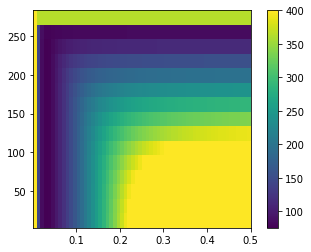

In [56]:
# Defining parameter ranges for the Gaussian
k_range = np.arange(3, 303, 20) # 3, 23, 43, 63... up to 303
sigma_range = np.linspace(.001, .5, 60) # cannot be zero, cause in gaussian is going to be in denominator

# Initializing some output variables
sse_mat = np.zeros((len(k_range), len(sigma_range))) # matrix where we house all the results
all_kernels = [ [0] * len(sigma_range) for i in range(len(k_range))]  # 15 by 60 matrix of lists

# Double loop over the two parameters
for k_index in range(len(k_range)):
  for sigma_index in range(len(sigma_range)):
    # Creating Gaussian
    x = np.arange(-k_range[k_index], k_range[k_index]+1) / sampling_rate
    g_kernel = np.exp(-x**2 / (2 * sigma_range[sigma_index]**2))

    # Filtering signal via Convolution
    filtered_signal = np.convolve(noisy_signal, g_kernel / sum(g_kernel), mode='same')

    # Computing SSE
    sse_mat[k_index, sigma_index] = np.sum((filtered_signal - signal) ** 2)
    all_kernels[k_index][sigma_index] = g_kernel


# Plotting
plt.imshow(sse_mat, vmax=400,
           extent=[sigma_range[0], sigma_range[-1], k_range[0], k_range[-1]]);
plt.gca().set_aspect(1 / plt.gca().get_data_ratio())
plt.colorbar();

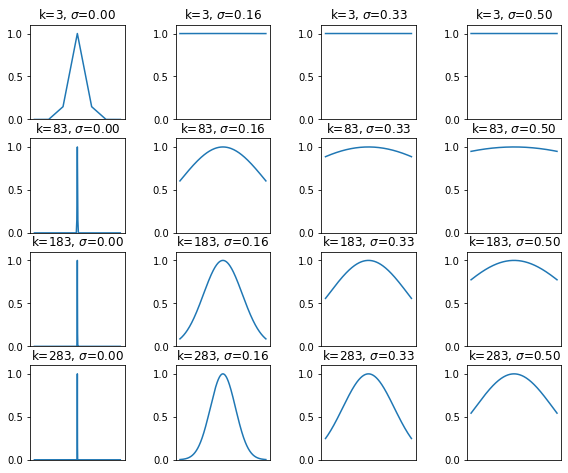

In [61]:
# Plotting a few non-randomly selected Gaussian kernels

fig, ax = plt.subplots(4, 4, figsize=(10, 8))

# 4 equally spaced points on the grid
sidx = np.linspace(0, len(sigma_range)-1, 4).astype(int)
kidx = np.linspace(0, len(k_range)-1, 4).astype(int)

for si in range(4):
  for kj in range(4):
    ax[kj, si].plot(all_kernels[kidx[kj]][sidx[si]])
    ax[kj, si].set_xticks([])
    ax[kj, si].set_ylim([0, 1.1])
    ax[kj, si].set_title('k=%g, $\sigma$=%.2f'%(k_range[kidx[kj]], sigma_range[sidx[si]]))
    ax[kj, si].set_aspect(1 / ax[kj, si].get_data_ratio())
    
plt.show()

Plotting the kernels that we created, we can interpret the sum of squared errors images, where sometimes the smoothing looks good (normal distribution approximate) and sometimes looks extreme (too narrow, or too wide).

## Despeckling via median filter

This is another kind of filter. It's a non-linear filter called median filter.

Median = central point of a SORTED list of data values

x = [0, 4, 1, -2, 7]

med(x) = 1

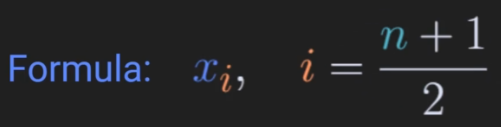

And below is the formula of the signal we are going to create.

The modulus operator is the remainder after a division.

So, we are going to take "t²" and dividing it by five, and getting its remainder... plus the noise "n".

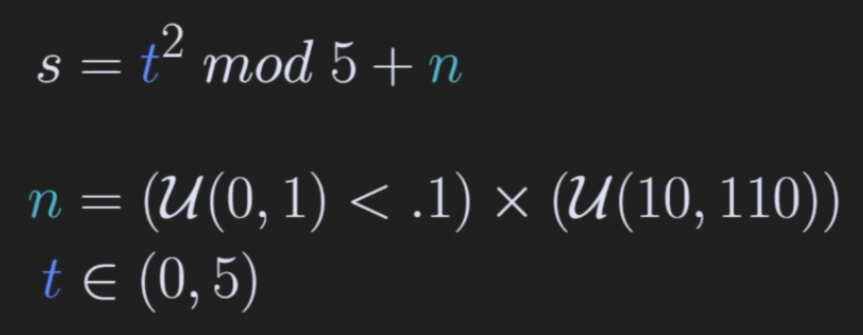

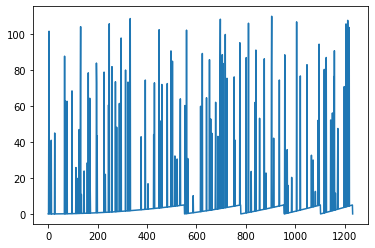

In [66]:
points = 1234
signal = np.mod(np.linspace(0, 5, points)**2, 5)
p = int(.1 * points)
spike_times = np.random.randint(0, points, p)
signal[spike_times] = np.random.rand(p) * 100 + 10

plt.plot(signal);

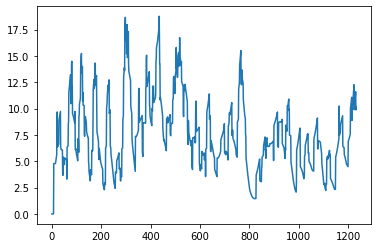

In [65]:
# trying mean-smoothing
k = 15

for i in range(points):
  signal[i]  = np.mean(signal[np.max((0, i-k)) : np.min((points, i+k))])

plt.plot(signal);

This is pretty bad. 

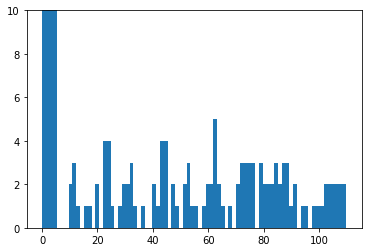

In [67]:
# empirically defining a threshhold for spikes

plt.hist(signal, 80)
plt.ylim([0, 10])
plt.show()

In [70]:
# let's pick a threshold of 8

threshold = 8

# findind all supra-threshold data indices
supra_threshold_index = np.where(signal > threshold)[0]
len(supra_threshold_index) / points

0.09562398703403566

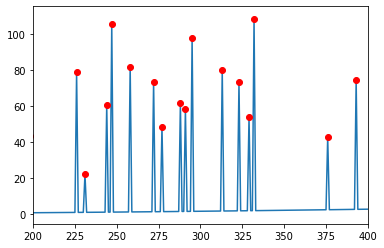

In [72]:
plt.plot(signal)
plt.plot(supra_threshold_index, signal[supra_threshold_index], 'ro')
plt.xlim([200, 400])
plt.show()

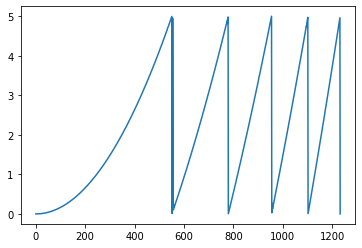

In [73]:
k = 7

for i in supra_threshold_index:
  lowbnd = np.max((0, i-k))
  uppbnd = np.min((points, i+k))
  signal[i] = np.median(signal[lowbnd : uppbnd])

plt.plot(signal)
plt.show()

Awesome! We recovered the signal.